In [1]:
%matplotlib inline

import glob
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as ml
import numpy
import pandas
import random
import seaborn

matplotlib.rcParams['axes.labelsize'] = 16
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['savefig.dpi'] = 300
seaborn.set_context({"figure.figsize": (12, 8)})

In [2]:
def calc_rho(species, basedir='../data'):
    """
    Calculate \rho, the proportion of iiLocus length to giLocus length,
    for a particular set of genomes.
    """
    files = ['{}/{}/{}.iloci.tsv'.format(basedir, s, s) for s in species]
    data = pandas.concat([pandas.read_csv(f,sep='\t') for f in files])
    giloci = data.loc[data.LocusClass.isin(['siLocus', 'ciLocus', 'niLocus'])]
    iiloci = data.loc[data.LocusClass.isin(['iiLocus'])]
    quant = list(giloci['Length'].quantile([0.05, 0.95]))
    giloci_q = giloci.loc[(giloci.Length >= quant[0]) & (giloci.Length <= quant[1])]
    quant = list(iiloci['Length'].quantile([0.05, 0.95]))
    iiloci_q = iiloci.loc[(iiloci.Length >= quant[0]) & (iiloci.Length <= quant[1])]
    rho = iiloci_q['Length'].mean() / giloci_q['Length'].mean()
    return rho

In [3]:
speciesnames = ['Daphnia pulex', 'Anopheles gambiae', 'Drosophila melanogaster',
                'Apis mellifera', 'Tribolium castaneum', 'Tetranychus urticae', ]
specieslist = ['Dpul', 'Agam', 'Dmel', 'Amel', 'Tcas', 'Turt']
palette = seaborn.color_palette("hls", len(specieslist))
rho = calc_rho(specieslist, basedir='../data')

data = pandas.read_csv('../tables/phisigma-Dpul.tsv',sep='\t')
plots = list()
for i, species in enumerate(specieslist):
    specdata = data.loc[(data.Species == species)]
    plot = plt.scatter(specdata['Phi'], specdata['Sigma'], color=palette[i])
    plots.append(plot)
    x = [k / 1000 for k in range(1000)]
    y = [(k/(1+(1-k)*rho)) for k in x]
    _ = plt.plot(x, y, color='#cccccc')
_ = plt.xlim(-0.02, 1.02)
_ = plt.ylim(-0.02, 1.02)
_ = plt.xlabel('φ (Proportion of giLoci merged into miLoci)')
_ = plt.ylabel('σ (Proportion of sequence occupied by miLoci)')
_ = plt.legend(plots, speciesnames, scatterpoints=1,
           loc='upper left',
           ncol=2,
           fontsize=12)
plt.savefig('../figures/LSB20GB-SuppFig5c.png')

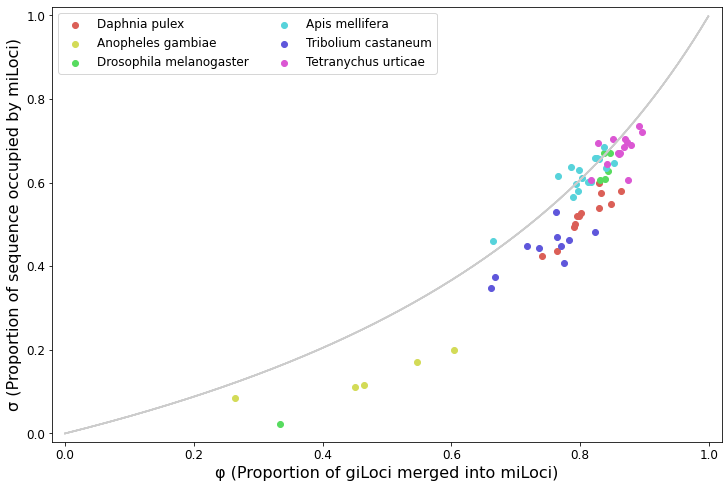

In [4]:
matplotlib.rcParams['axes.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14

In [5]:
def draw_hist(data, series, species, numbins=25, mybins=None, density=True,
              xlabel=None, xlim=None, xticks=None, xticklabs=None,
              ylabel='Density', ylim=None, yticks=None, yticklabs=None,
              palette=None):
    
    alldata = list()
    for spec in species:
        subdata = data.loc[data.Species == spec]
        alldata.append(subdata[series])

    if not mybins:
        mybins = numbins
        if xlim:
            mybins = numpy.linspace(xlim[0], xlim[1], numbins)

    fig, ax = plt.subplots()
    plot = ax.hist(alldata, bins=mybins, color=palette, density=density, label=species)

    if xlabel is not None:
        _ = ax.set_xlabel(xlabel)
    if xticks is not None:
        _ = ax.set_xticks(xticks)
    if xticklabs is not None:
        _ = ax.set_xticklabels(xticklabs)
    if ylabel is not None:
        _ = ax.set_ylabel(ylabel)
    if yticks is not None:
        _ = ax.set_yticks(yticks)
    if yticklabs is not None:
        _ = ax.set_yticklabels(yticklabs)
    if xlim:
        _ = ax.set_xlim(xlim[0], xlim[1])
    if ylim:
        _ = ax.set_ylim(ylim[0], ylim[1])
    _ = ax.legend(loc='upper right', ncol=1, fontsize=12)
    
    # Cleanup
    seaborn.despine(left=True)
    _ = matplotlib.pyplot.title("")
    _ = matplotlib.pyplot.suptitle("")

In [6]:
def load_data(pattern, loglength=True):
    filelist = glob.glob(pattern)
    data = pandas.concat([pandas.read_csv(f,sep='\t') for f in filelist])
    data['Length'] = data['Length'].astype(int)
    if loglength:
        data['LogLength'] = numpy.log10(data['Length'])
    return data

In [7]:
def silocus_mrnas(pattern, silocus_ids):
    filelist = glob.glob(pattern)
    data = pandas.concat([pandas.read_csv(f, sep='\t', header=None, names=('iLocusID', 'MrnaAccession')) for f in filelist])
    subdata = data.loc[data.iLocusID.isin(silocus_ids)]
    return list(subdata['MrnaAccession'])

## Exploring iiLocus space:

In [8]:
iloci = load_data('../data/*/*.iloci.tsv')
idf = iloci.groupby(['Species']).sum()
iiloci = iloci[iloci['LocusClass'] == 'iiLocus']
iidf = iiloci.groupby(['Species']).sum()
iidf['Occupancy'] = 100.*iidf['EffectiveLength']/idf['EffectiveLength']
display(iidf)

,Length,EffectiveLength,GCContent,GCSkew,NContent,GeneCount,SeqUnannot,LogLength,Occupancy
Species,,,,,,,,,
Acen,424954478,424954478,7629.774,-7.398,61.271,0,False,72702.499379,45.550504
Aech,80110977,80110977,1789.338,4.558,95.521,0,False,21529.391442,27.069562
Agam,149186378,149186378,3287.247,-4.769,158.280,0,False,29558.062413,56.294265
Amel,45855736,45855736,998.729,-3.267,8.104,0,False,13633.210790,20.359105
Apro,1668492,1668492,500.586,3.767,67.019,0,False,2746.315508,7.278161
Atha,35247288,35247288,2540.495,7.051,1.377,0,False,27533.916695,29.583188
Bdis,151027171,151027171,7843.892,-22.542,6.988,0,False,63229.214072,55.525245
Bter,63966268,63966268,1259.125,7.311,294.009,0,False,13834.831710,25.724985
Cele,17949597,17949597,2102.426,-5.258,0.000,0,False,20345.425749,17.900798


In [9]:
iiloci.groupby(['Species']).median().sort_values(by='Length')

,Length,EffectiveLength,GCContent,GCSkew,NContent,GeneCount,SeqUnannot,LogLength
Species,,,,,,,,
Otau,940.0,940.0,0.5710,0.0215,0.0,0.0,False,2.973019
Oluc,1029.0,1029.0,0.6160,0.0130,0.0,0.0,False,3.012415
Scer,1030.5,1030.5,0.3640,0.0000,0.0,0.0,False,3.013048
Apro,1219.5,1219.5,0.5690,0.0010,0.0,0.0,False,3.086182
Mpus,1244.0,1244.0,0.6820,0.0030,0.0,0.0,False,3.094820
Mcom,1285.5,1285.5,0.6505,0.0050,0.0,0.0,False,3.109072
Csub,1555.5,1555.5,0.5060,0.0000,0.0,0.0,False,3.191870
Cele,1926.0,1926.0,0.3370,0.0000,0.0,0.0,False,3.284656
Atha,1933.5,1933.5,0.3010,0.0010,0.0,0.0,False,3.286344


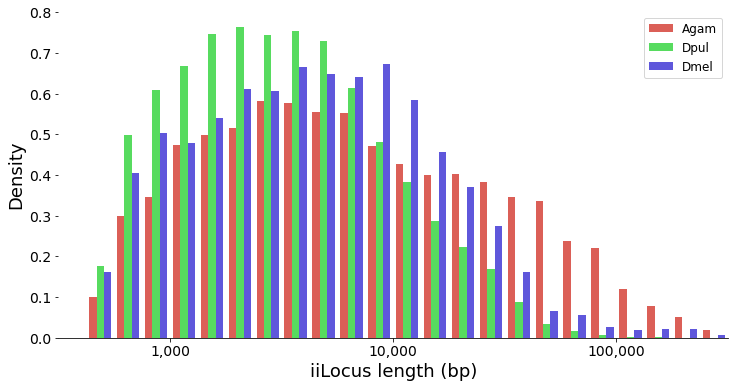

In [10]:
seaborn.set_context({"figure.figsize": (12, 6)})
specieslist = ['Agam', 'Dpul', 'Dmel']
draw_hist(iiloci, 'LogLength', species=specieslist,
          palette=seaborn.color_palette("hls", len(specieslist)),
          xlabel='iiLocus length (bp)', xlim=(2.5, 5.5),
          xticks=(3,4,5), xticklabs=('1,000', '10,000', '100,000'))
plt.savefig('../figures/LSB20GB-SuppFig8-ii-lengths.png')

## Exploring siLocus space:

In [11]:
siloci = iloci[iloci['LocusClass'] == 'siLocus']
siloci.groupby(['Species']).median().sort_values(by='Length')

,Length,EffectiveLength,GCContent,GCSkew,NContent,GeneCount,SeqUnannot,LogLength
Species,,,,,,,,
Otau,2050.0,1270.0,0.6060,0.001,0.0,1.0,False,3.311754
Oluc,2052.0,1424.0,0.6190,0.000,0.0,1.0,False,3.312177
Scer,2215.0,1656.0,0.3780,-0.001,0.0,1.0,False,3.345374
Mcom,2271.0,1628.0,0.6520,0.002,0.0,1.0,False,3.356217
Mpus,2280.5,1659.5,0.6720,0.000,0.0,1.0,False,3.358030
Dpul,2306.0,2076.0,0.4030,0.000,0.0,1.0,False,3.362859
Mtru,2743.0,2671.0,0.3370,0.000,0.0,1.0,False,3.438226
Apro,2858.0,2469.5,0.6310,0.000,0.0,1.0,False,3.456062
Agam,2993.5,2798.0,0.4795,0.000,0.0,1.0,False,3.476179


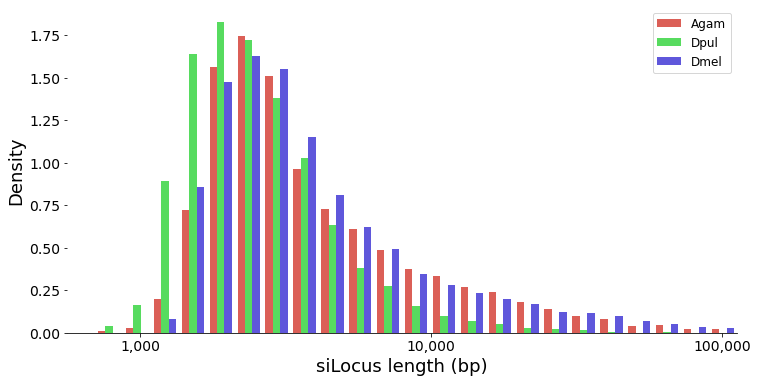

In [12]:
seaborn.set_context({"figure.figsize": (12, 6)})
specieslist = ['Agam', 'Dpul', 'Dmel']
draw_hist(siloci, 'LogLength', species=specieslist,
          palette=seaborn.color_palette("hls", len(specieslist)),
          xlabel='siLocus length (bp)', xlim=(2.75, 5.05),
          xticks=(3,4,5), xticklabs=('1,000', '10,000', '100,000'))
plt.savefig('../figures/LSB20GB-SuppFig8-si-lengths.png')

## What are the contributions of exon counts per gene and exon length?

In [13]:
premrnas = load_data('../data/*/*.pre-mrnas.tsv')
silocus_ids = siloci['LocusId']
silocus_mrna_ids = silocus_mrnas('../data/*/*.ilocus.mrnas.tsv', silocus_ids)
silocus_premrnas = premrnas.loc[premrnas.Accession.isin(silocus_mrna_ids)].copy()
silocus_premrnas['ExonCountMax'] = [min(x, 20) for x in silocus_premrnas['ExonCount']]

In [14]:
silocus_premrnas.groupby(['Species']).median().sort_values(by='ExonCount')

,Length,GCContent,GCSkew,NContent,ExonCount,IntronCount,5pUTRlen,3pUTRlen,LogLength,ExonCountMax
Species,,,,,,,,,,
Mcom,1260.0,0.657,0.057,0.0,1.0,0.0,0.0,0.0,3.100371,1.0
Otau,1049.0,0.602,0.111,0.0,1.0,0.0,0.0,0.0,3.020775,1.0
Oluc,1038.0,0.604,0.125,0.0,1.0,0.0,0.0,0.0,3.016197,1.0
Scer,1203.0,0.397,0.050,0.0,1.0,0.0,0.0,0.0,3.080266,1.0
Mpus,1268.5,0.674,0.056,0.0,2.0,1.0,0.0,0.0,3.103290,2.0
Mtru,1718.0,0.354,0.056,0.0,3.0,2.0,0.0,0.0,3.235023,3.0
Agam,1956.0,0.506,0.023,0.0,3.0,2.0,0.0,0.0,3.291369,3.0
Turt,2288.5,0.333,-0.022,0.0,3.0,2.0,193.0,212.0,3.359551,3.0
Dmel,1962.0,0.463,-0.004,0.0,3.0,2.0,109.0,163.0,3.292699,3.0


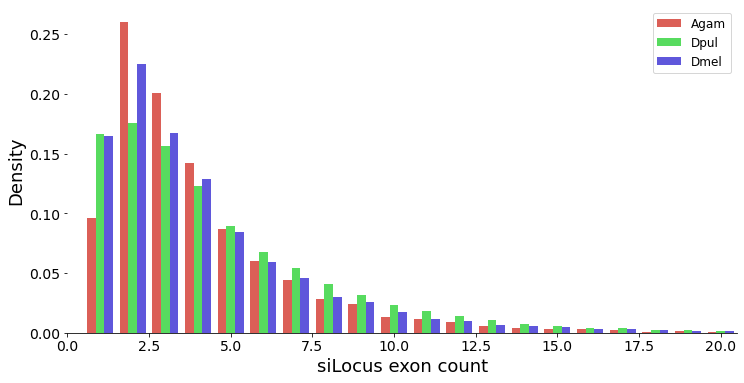

In [15]:
seaborn.set_context({"figure.figsize": (12, 6)})
specieslist = ['Agam', 'Dpul', 'Dmel']
draw_hist(silocus_premrnas, 'ExonCount', species=specieslist,
          palette=seaborn.color_palette("hls", len(specieslist)),
          mybins=[x - 0.5 for x in range(1, 22)], xlabel='siLocus exon count', xlim=(0, 20.5))
plt.savefig('../figures/LSB20GB-SuppFig8-si-exon-counts.png')
plt.show()

In [16]:
exons = load_data('../data/*/*.exons.tsv', loglength=True)
exons = exons.loc[exons.MrnaAcc.isin(silocus_mrna_ids)]
exons.head()

,Species,ExonPos,MrnaAcc,Length,GCContent,GCSkew,NContent,Context,Phase,Remainder,LogLength
0,Crei,NW_001843471.1_1965-2102+,XM_001689361.1,138,0.565,0.051,0.0,start,None,None,2.139879
1,Crei,NW_001843471.1_2164-2226+,XM_001689361.1,63,0.524,0.030,0.0,cds,0,0,1.799341
2,Crei,NW_001843471.1_2327-2601+,XM_001689361.1,275,0.698,0.260,0.0,cds,0,2,2.439333
3,Crei,NW_001843471.1_2945-3930+,XM_001689361.1,986,0.623,0.257,0.0,stop,None,None,2.993877
4,Crei,NW_001843471.1_6021-7003-,XM_001689813.1,983,0.613,0.227,0.0,stop,None,None,2.992554


In [17]:
exons.groupby(['Species']).median().sort_values(by=['Length'])

,Length,GCContent,GCSkew,NContent,LogLength
Species,,,,,
Cvar,121.0,0.668,0.0440,0.0,2.082785
Crei,123.0,0.667,0.0410,0.0,2.089905
Mvit,130.0,0.479,0.0480,0.0,2.113943
Clan,132.0,0.493,0.0430,0.0,2.120574
Lcan,133.0,0.516,0.0260,0.0,2.123852
Xtro,134.0,0.454,0.0480,0.0,2.127105
Hsap,135.0,0.504,0.0285,0.0,2.130334
Drer,135.0,0.484,0.0400,0.0,2.130334
Acen,135.0,0.500,0.0310,0.0,2.130334


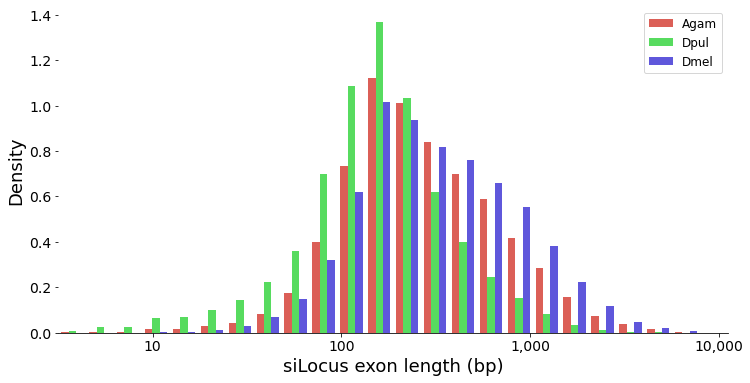

In [18]:
seaborn.set_context({"figure.figsize": (12, 6)})
specieslist = ['Agam', 'Dpul', 'Dmel']
draw_hist(exons, 'LogLength', species=specieslist,
          palette=seaborn.color_palette("hls", len(specieslist)),
          xlabel='siLocus exon length (bp)', xlim=(0.5, 4.05),
          xticks=(1,2,3,4), xticklabs=('10', '100', '1,000', '10,000'))
plt.savefig('../figures/LSB20GB-SuppFig8-si-exon-lengths.png')

## Exploring intron space:

In [19]:
introns = load_data('../data/*/*.introns.tsv', loglength=True)
introns = introns.loc[introns.MrnaAcc.isin(silocus_mrna_ids)]
introns.head()

,Species,IntronPos,MrnaAcc,Length,GCContent,GCSkew,NContent,Context,LogLength
0,Crei,NW_001843471.1_2103-2163+,XM_001689361.1,61,0.639,0.128,0.0,cds,1.785330
1,Crei,NW_001843471.1_2227-2326+,XM_001689361.1,100,0.480,-0.167,0.0,cds,2.000000
2,Crei,NW_001843471.1_2602-2944+,XM_001689361.1,343,0.644,0.131,0.0,cds,2.535294
3,Crei,NW_001843471.1_7004-7206-,XM_001689813.1,203,0.601,-0.066,0.0,cds,2.307496
4,Crei,NW_001843471.1_7267-7359-,XM_001689813.1,93,0.624,0.207,0.0,cds,1.968483


In [20]:
print("Intron counts per species:")
introns.groupby(['Species']).count()['MrnaAcc']

Intron counts per species:


Species
Acen    221012
Aech     59800
Agam     37290
Amel     59702
Apro     30649
Atha    117514
Bdis    110929
Bter     54508
Cele    102006
Cflo     61789
Clan    143269
Crei    105745
Csub     69619
Cvar     71219
Dmel     40093
Dpul    113328
Drer    224165
Hsal     64210
Hsap    178228
Lcan    152400
Mcom      5480
Mmus    181036
Mpus      9226
Mtru    159348
Mvit    133660
Nvit     68557
Oluc      2198
Osat    122627
Otau      6214
Pcan     59663
Pdom     60514
Scer       270
Tcas     50542
Turt     34488
Vcar    101207
Xtro    181813
Name: MrnaAcc, dtype: int64

In [21]:
introns.groupby(['Species']).median().sort_values(by=['Length'])

,Length,GCContent,GCSkew,NContent,LogLength
Species,,,,,
Otau,52,0.5895,0.100,0.0,1.716003
Tcas,53,0.3110,0.050,0.0,1.724276
Cele,65,0.2880,0.028,0.0,1.812913
Dmel,70,0.3590,-0.017,0.0,1.845098
Dpul,75,0.3070,0.000,0.0,1.875061
Nvit,89,0.3030,0.000,0.0,1.949390
Agam,91,0.4320,0.000,0.0,1.959041
Atha,100,0.3270,0.034,0.0,2.000000
Turt,102,0.2760,-0.082,0.0,2.008600


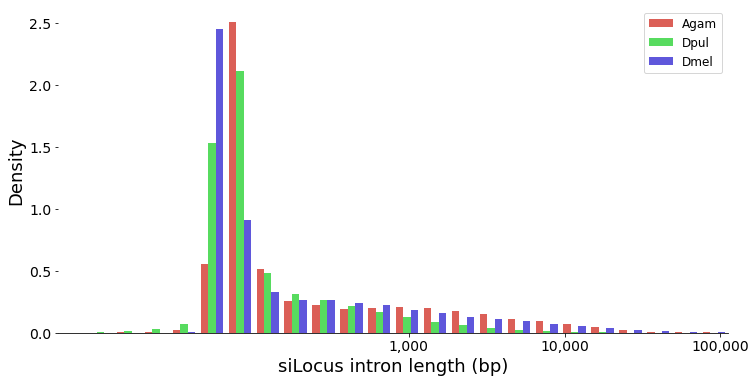

In [22]:
seaborn.set_context({"figure.figsize": (12, 6)})
specieslist = ['Agam', 'Dpul', 'Dmel']
draw_hist(introns, 'LogLength', species=specieslist,
          palette=seaborn.color_palette("hls", len(specieslist)),
          xlabel='siLocus intron length (bp)', xlim=(0.75, 5.05),
          xticks=(3,4,5), xticklabs=('1,000', '10,000', '100,000'))
plt.savefig('../figures/LSB20GB-SuppFig8-si-intron-lengths.png')